In [141]:
from config import api_key, neptune_key
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical as np_utils

stockCode = '603936.SH'
lastDate = '20240322'

In [142]:
import tushare as ts

ts.set_token('94cd405b2c1adff88930d17a3a3d6e5c0c53f4dc4945aeb264b2be3a')  # Set your tushare token
pro = ts.pro_api()

df = pro.daily(ts_code=stockCode, start_date='19900101', end_date=lastDate)
print(df)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     603936.SH   20240322   8.27   9.11   8.24   8.96       8.28    0.68   
1     603936.SH   20240321   8.25   8.38   8.16   8.28       8.18    0.10   
2     603936.SH   20240320   8.13   8.22   8.07   8.18       8.11    0.07   
3     603936.SH   20240319   8.07   8.25   8.03   8.11       8.07    0.04   
4     603936.SH   20240318   7.96   8.07   7.89   8.07       7.85    0.22   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1912  603936.SH   20151215  17.01  17.01  17.01  17.01      15.46    1.55   
1913  603936.SH   20151214  15.46  15.46  15.46  15.46      14.05    1.41   
1914  603936.SH   20151211  14.05  14.05  14.05  14.05      12.77    1.28   
1915  603936.SH   20151210  12.77  12.77  12.77  12.77      11.61    1.16   
1916  603936.SH   20151209  11.61  11.61  11.61  11.61       8.06    3.55   

      pct_chg        vol      amount  
0      8.2126  774738.46  690639.798

In [143]:

# Adjusting the DataFrame to match the target data structure with modified keys
last_refreshed_date = df.iloc[0]['trade_date'] if not df.empty else 'N/A'  # Assuming the first row is the latest
data = {
    "Meta Data": {
        "1. Information": "Daily Prices (open, high, low, close) and Volumes",
        "2. Symbol": stockCode,
        "3. Last Refreshed": last_refreshed_date,
        "4. Output Size": "Full size",
        "5. Time Zone": "Asia/Shanghai"
    },
    "Time Series (Daily)": {date: {"1. open": str(row['open']), "2. high": str(row['high']), "3. low": str(row['low']), "4. close": str(row['close']), "5. volume": str(row['vol'])} for date, row in df.set_index('trade_date').iterrows()}
}

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': '603936.SH', '3. Last Refreshed': '20240322', '4. Output Size': 'Full size', '5. Time Zone': 'Asia/Shanghai'}, 'Time Series (Daily)': {'20240322': {'1. open': '8.27', '2. high': '9.11', '3. low': '8.24', '4. close': '8.96', '5. volume': '774738.46'}, '20240321': {'1. open': '8.25', '2. high': '8.38', '3. low': '8.16', '4. close': '8.28', '5. volume': '206545.79'}, '20240320': {'1. open': '8.13', '2. high': '8.22', '3. low': '8.07', '4. close': '8.18', '5. volume': '121568.06'}, '20240319': {'1. open': '8.07', '2. high': '8.25', '3. low': '8.03', '4. close': '8.11', '5. volume': '158261.88'}, '20240318': {'1. open': '7.96', '2. high': '8.07', '3. low': '7.89', '4. close': '8.07', '5. volume': '154357.41'}, '20240315': {'1. open': '7.72', '2. high': '7.85', '3. low': '7.63', '4. close': '7.85', '5. volume': '102180.37'}, '20240314': {'1. open': '7.83', '2. high': '7.89', '3. low': '7.63', '

In [144]:
sz000001_df_json = pd.DataFrame.from_dict(data, orient='index')
sz000001_df_json

,1. Information,2. Symbol,3. Last Refreshed,4. Output Size,5. Time Zone,20240322,20240321,20240320,20240319,20240318,...,20151222,20151221,20151218,20151217,20151216,20151215,20151214,20151211,20151210,20151209
Meta Data,"Daily Prices (open, high, low, close) and Volumes",603936.SH,20240322,Full size,Asia/Shanghai,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time Series (Daily),NaN,NaN,NaN,NaN,NaN,"{'1. open': '8.27', '2. high': '9.11', '3. low...","{'1. open': '8.25', '2. high': '8.38', '3. low...","{'1. open': '8.13', '2. high': '8.22', '3. low...","{'1. open': '8.07', '2. high': '8.25', '3. low...","{'1. open': '7.96', '2. high': '8.07', '3. low...",...,"{'1. open': '27.39', '2. high': '27.39', '3. l...","{'1. open': '24.9', '2. high': '24.9', '3. low...","{'1. open': '22.64', '2. high': '22.64', '3. l...","{'1. open': '20.58', '2. high': '20.58', '3. l...","{'1. open': '18.71', '2. high': '18.71', '3. l...","{'1. open': '17.01', '2. high': '17.01', '3. l...","{'1. open': '15.46', '2. high': '15.46', '3. l...","{'1. open': '14.05', '2. high': '14.05', '3. l...","{'1. open': '12.77', '2. high': '12.77', '3. l...","{'1. open': '11.61', '2. high': '11.61', '3. l..."


In [145]:
df_tushare = pro.daily(ts_code=stockCode, start_date='19900101', end_date=lastDate)
historical_price_csv_df = pd.DataFrame({
    "timestamp": df_tushare["trade_date"],
    "open": df_tushare["open"],
    "high": df_tushare["high"],
    "low": df_tushare["low"],
    "close": df_tushare["close"],
    "volume": df_tushare["vol"]
})
print(historical_price_csv_df)


     timestamp   open   high    low  close     volume
0     20240322   8.27   9.11   8.24   8.96  774738.46
1     20240321   8.25   8.38   8.16   8.28  206545.79
2     20240320   8.13   8.22   8.07   8.18  121568.06
3     20240319   8.07   8.25   8.03   8.11  158261.88
4     20240318   7.96   8.07   7.89   8.07  154357.41
...        ...    ...    ...    ...    ...        ...
1912  20151215  17.01  17.01  17.01  17.01     107.00
1913  20151214  15.46  15.46  15.46  15.46     137.00
1914  20151211  14.05  14.05  14.05  14.05      93.15
1915  20151210  12.77  12.77  12.77  12.77      60.00
1916  20151209  11.61  11.61  11.61  11.61     226.00

[1917 rows x 6 columns]


In [146]:
len(historical_price_csv_df.close)

1917

In [147]:
df_copy = historical_price_csv_df.copy()

In [148]:
date_close_df = df_copy.filter(['timestamp','close'], axis=1).iloc[::-1]
date_close_df

,timestamp,close
1916,20151209,11.61
1915,20151210,12.77
1914,20151211,14.05
1913,20151214,15.46
1912,20151215,17.01
...,...,...
4,20240318,8.07
3,20240319,8.11
2,20240320,8.18
1,20240321,8.28


In [149]:
date_close_df.tail(5)

,timestamp,close
4,20240318,8.07
3,20240319,8.11
2,20240320,8.18
1,20240321,8.28
0,20240322,8.96


In [150]:
stockprices = date_close_df

In [151]:
#### Train-Test split for time-series ####
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print("train_size: " + str(train_size))
print("test_size: " + str(test_size))

train = stockprices[:train_size][['timestamp', 'close']]
test = stockprices[train_size:][['timestamp', 'close']]

train_size: 1533
test_size: 383


In [152]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset 
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

In [153]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [154]:
def plot_stock_trend(var, cur_title, stockprices=stockprices, logNeptune=True, logmodelName='Simple MA'):
    ax = stockprices[['close', var,'200day']].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')

In [155]:
window_size = 50

import neptune

window_var = str(window_size) + 'day'

In [156]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 50
cur_batch_size = 20
    
cur_LSTM_pars = {'units': layer_units, 
                 'optimizer': optimizer, 
                 'batch_size': cur_batch_size, 
                 'epochs': cur_epochs
                 }

In [157]:
# scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['close']])
scaled_data_train = scaled_data[:train.shape[0]]
    
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

In [158]:
### Build a LSTM model and log model summary to Neptune ###    
def Run_LSTM(X_train, layer_units=50):     
    inp = Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = tf.keras.Model(inp, out)  # Corrected keras.Model to tf.keras.Model
    
    # Compile the LSTM neural net
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model   

model = Run_LSTM(X_train, layer_units=layer_units)

history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2931 - val_loss: 0.0162
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0375 - val_loss: 0.0133
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0299 - val_loss: 0.0134
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0333 - val_loss: 0.0099
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0218 - val_loss: 0.0091
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0230 - val_loss: 0.0079
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0225 - val_loss: 0.0073
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0176 - val_loss: 0.0085
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0166 - val_loss: 0.0064
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0170 - val_loss: 0.0070
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0162 - val_loss: 0.0055
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

In [159]:
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):    
    raw = data[['close']].iloc[len(data) - len(test) - window_size:].values
    # To avoid the warning, ensure the data passed to scaler.transform() has the same structure as the data used in scaler.fit()
    # Specifically, ensure it's a DataFrame with column names matching those used in fitting.
    raw_df = pd.DataFrame(raw, columns=['close'])
    raw_scaled = scaler.transform(raw_df)
    
    X_test = []
    for i in range(window_size, raw_scaled.shape[0]):
        X_test.append(raw_scaled[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price 
test['Predictions_lstm'] = predicted_price

# 打印最后1天的日期和最后2天的实际值和预测值
last_day = test.iloc[-1]['timestamp']
last_day_actual_close = test.iloc[-1]['close']
last_day_predicted_close = test.iloc[-1]['Predictions_lstm']
second_last_day_actual_close = test.iloc[-2]['close']
second_last_day_predicted_close = test.iloc[-2]['Predictions_lstm']

print(f"最后1天的日期: {last_day}")
print(f"最后1天的实际收盘价: {last_day_actual_close}, 预测收盘价: {last_day_predicted_close}")
print(f"倒数第二天的实际收盘价: {second_last_day_actual_close}, 预测收盘价: {second_last_day_predicted_close}")

# 预测后面两个交易日的收盘价
# Instead of calculating future dates, use "T+1" and "T+2"
future_dates = ["T+1", "T+2"]
future_raw = np.array([predicted_price[-1]]).reshape(-1,1)  # Assuming the last predicted price for future prediction
# Use a DataFrame for future_raw to match the structure expected by scaler
future_raw_df = pd.DataFrame(future_raw, columns=['close'])
future_raw_scaled = scaler.transform(future_raw_df)

# Corrected future prediction preprocessing to match the expected input shape for the model
future_X_test = np.repeat(future_raw_scaled.T, window_size, axis=0).reshape(1, window_size, 1)
future_predicted_price_ = model.predict(future_X_test)
future_predicted_price = scaler.inverse_transform(future_predicted_price_)

# 预测“T+1”的收盘价
print(f"{future_dates[0]}预测收盘价: {future_predicted_price[0][0]}")

# 使用“T+1”的预测值来预测“T+2”
future_raw_next_day = np.array([future_predicted_price[-1]]).reshape(-1,1)
# Again, use a DataFrame for future_raw_next_day
future_raw_next_day_df = pd.DataFrame(future_raw_next_day, columns=['close'])
future_raw_next_day_scaled = scaler.transform(future_raw_next_day_df)
future_X_test_next_day = np.repeat(future_raw_next_day_scaled.T, window_size, axis=0).reshape(1, window_size, 1)
future_predicted_price_next_day_ = model.predict(future_X_test_next_day)
future_predicted_price_next_day = scaler.inverse_transform(future_predicted_price_next_day_)

# 预测“T+2”的收盘价
print(f"{future_dates[1]}预测收盘价: {future_predicted_price_next_day[0][0]}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
最后1天的日期: 20240322
最后1天的实际收盘价: 8.96, 预测收盘价: 8.503053665161133
倒数第二天的实际收盘价: 8.28, 预测收盘价: 8.419878005981445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
T+1预测收盘价: 8.740952491760254
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
T+2预测收盘价: 8.96485710144043


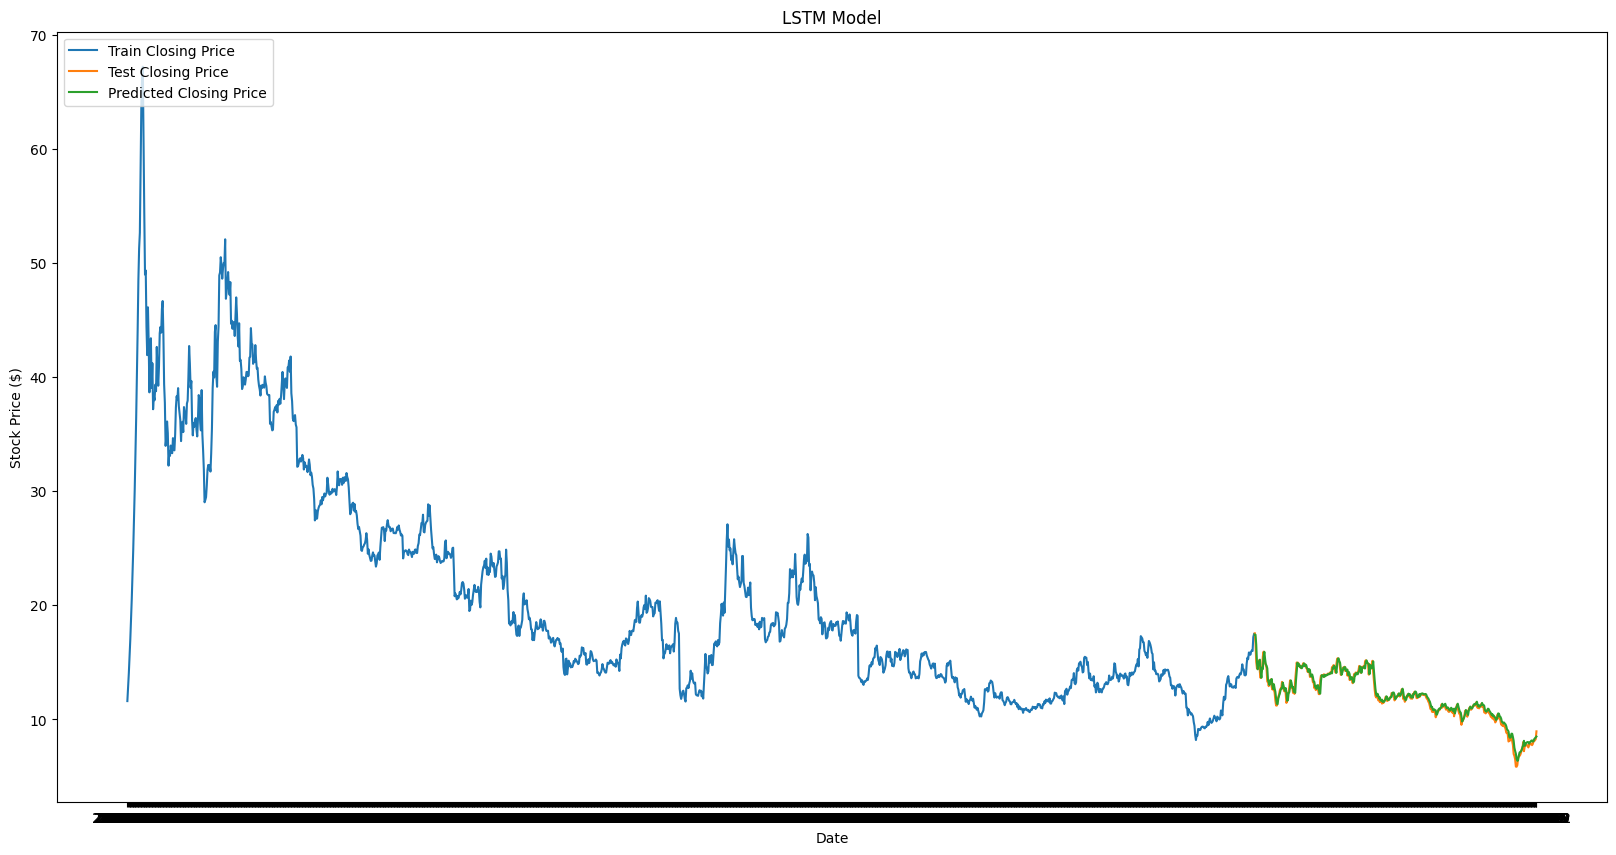

In [160]:

### Plot prediction and true trends and log to Neptune         
def plot_stock_trend_lstm(train, test, logNeptune=True):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['timestamp'], train['close'], label = 'Train Closing Price')
    plt.plot(test['timestamp'], test['close'], label = 'Test Closing Price')
    plt.plot(test['timestamp'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")
    
plot_stock_trend_lstm(train, test)

### Stop the run after logging for new version 
